# MLPs for Image Classification

> *Deep Learning*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

#### *Description*

<p style='text-align: justify;'>Given an image of a fashion item, build a deep learning model that recognizes the fashion item. You must use at least 2 different architectures, one with MLPs and one with CNNs. Use the Fashion-MNIST dataset to train and evaluate your models. More information about the task and the dataset can be found at <a href="https://github.com/zalandoresearch/fashion-mnist">https://github.com/zalandoresearch/fashion-mnist</a>. The dataset is also available from Tensorflow.</p>

## *Table of Contents*

- [*1. Introduction*](#introduction)
    - [*1.1. Libraries*](#libraries)
    - [*1.2. Data*](#data)
- [*2. MLP*](#mlp)
    - [*2.1. Model Architecture*](#mlp_architecture)
    - [*2.2. Hyperparameter Tuning*](#mlp_hp_tuning)
    - [*2.3. Model Training*](#mlp_training)
    - [*2.4. Model Evaluation*](#mlp_evaluation)

---

## Introduction <a class='anchor' id='introduction'></a>

### *Libraries* <a class='anchor' id='libraries'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import gc
import time

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras import backend as K # importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model # the class used to create a model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.7.0


##### *Initialize some variables needed in order to have reproducible experiments*

In [2]:
SEED = 2023
np.random.seed(SEED) # seed for numpy to have reproducible experiments
set_seed(SEED) # seed for Tensorflow to have reproducible experiments

##### *Define a function to clean up the model*

In [3]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

### *Data* <a class='anchor' id='data'></a>

<p style='text-align: justify;'>The Fashion-MNIST dataset is a collection of 70,000 images of clothing items, such as t-shirts, dresses, and shoes, each with a resolution of 28x28 pixels. It is commonly used as a benchmark dataset in machine learning and computer vision research, serving as a replacement for the traditional MNIST dataset of handwritten digits.</p>

<p style='text-align: justify;'>The dataset was created by researchers at the Zalando Research group in 2017, with the aim of providing a more challenging and realistic dataset for image classification tasks. It has become a popular dataset for testing and comparing different machine learning algorithms, and has been used in a wide range of applications, such as object detection, image segmentation, and generative models.</p>

##### *Load data*

In [4]:
# load fashion mnist dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# x_train = x_train.reshape(60000, 784)
# x_test = x_test.reshape(10000, 784)

# change type for efficiency
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalization
x_train /= 255
x_test /= 255

# 2D numpy array of one-hot encoded labels
classes = 10
y_train_cat = to_categorical(y_train, classes)
y_test_cat = to_categorical(y_test, classes)

##### *Preview a few images*

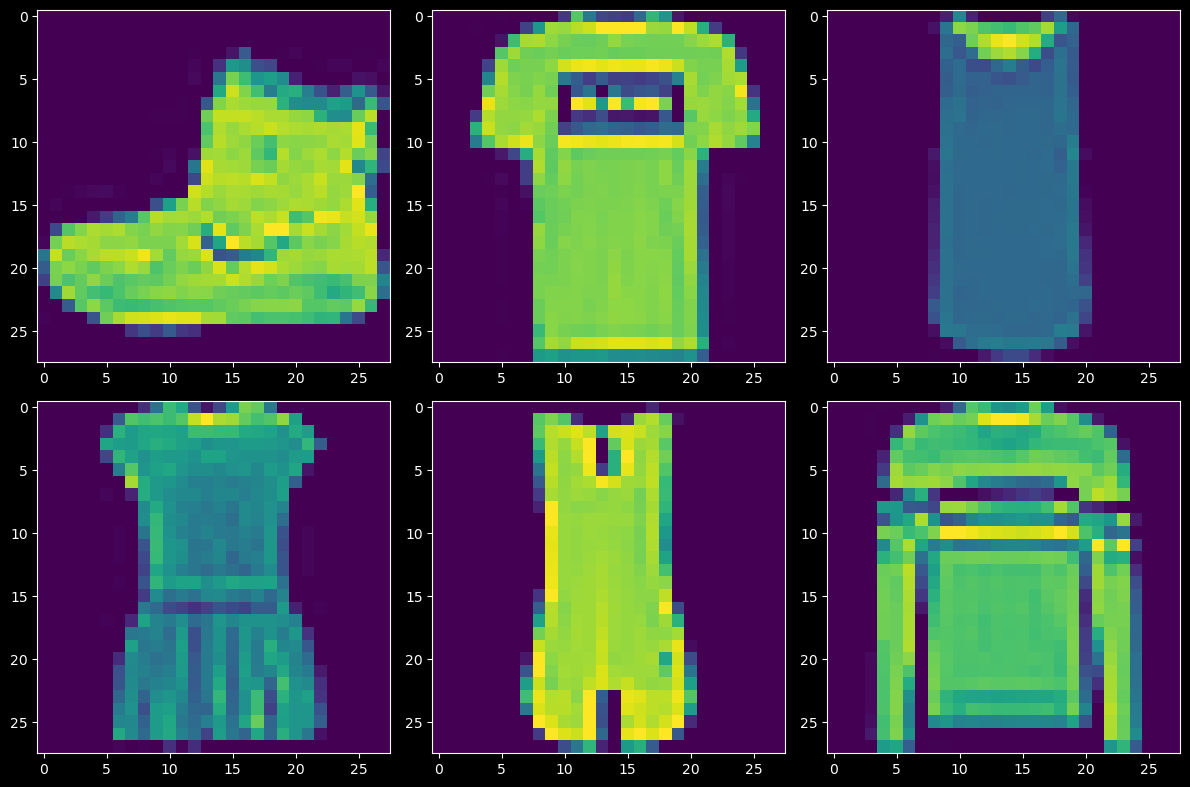

In [5]:
# plot a sample of images
plt.style.use('dark_background')
fig, ax = plt.subplots(2,3,figsize=(12,8),dpi=100)
ax[0,0].imshow(x_train[0])
ax[0,1].imshow(x_train[1])
ax[0,2].imshow(x_train[2])
ax[1,0].imshow(x_train[3])
ax[1,1].imshow(x_train[4])
ax[1,2].imshow(x_train[5])
plt.tight_layout()
plt.savefig('./images/image_samples.svg')
plt.show()

## MLP <a class='anchor' id='mlp'></a>

<p style='text-align: justify;'>Multilayer Perceptron (MLP) is a type of artificial neural network (ANN) that is commonly used in machine learning and deep learning. It consists of multiple layers of neurons, with each layer being fully connected to the next one. The MLP is a feedforward neural network, which means that the data flows from the input layer through the hidden layers to the output layer.</p>

### *Model Architecture* <a class='anchor' id='mlp_architecture'></a>

- *Input Layer*
- *Flatten Layer*
- *X sets of:*
    - *Dense Layer*
    - *Batch Normalization Layer*
    - *Dropout Layer*
- *Output Dense Layer*

##### *Define a function to build a custom MLP model*

In [6]:
def build_model(input_shape:tuple=(28,28),
                learning_rate:float=1e-4,
                hidden_layers:int=1, # number of hidden layers, if 0 then equal to LogReg
                hidden_units:int=256, # number of neurons per hidden layer
                hidden_activation:str='relu', # activation function for hidden layers
                hidden_dropout_prob:float=0.5, # dropout probability for neurons in hidden layers
                output_activation:str='softmax' # activation function for output layer
               ):
    
    # define the input layer
    input = Input(
            shape=input_shape,
            name='Input'
    )
    x = input
    
    # flatten input layer
    # convert it from (28,28) to (784,)
    x = Flatten(
        name='Flatten'
    )(x)
    
    # define the remaining hidden layers
    for i in range(hidden_layers):
        
        # add a dense layer
        x = Dense(
            units=hidden_units,
            kernel_initializer='glorot_uniform',
            activation=hidden_activation,
            name=f'Hidden-{i+1}'
        )(x)
        
        # add a batch normalization layer
        x = BatchNormalization(
            name=f'BatchNormalization-{i+1}'
        )(x)
        
        # add a dropout layer
        x = Dropout(
            rate=hidden_dropout_prob,
            name=f'Dropout-{i+1}'
        )(x)
        
    # define the output layer
    output = Dense(
             units=10, # number of classes in this case
             kernel_initializer='glorot_uniform',
             activation=output_activation,
             name='Output'
    )(x)
    
    # define the model
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

### *Hyperparameter Tuning* <a class='anchor' id='mlp_hp_tuning'></a>

- *In this step, we will slightly tune some of the hyperparameters of the model*
- *We will also use some callbacks to gain a little more control over the model performance*
- *In particular, we will use two callbacks, `EarlyStopping` and `ReduceLROnPlateau`*
- *`EarlyStopping` will help monitor the progress of the training and stop it in case there is no progress over a few epochs*
- *`ReduceLROnPlateau` will monitor the progress of the training and change the learning rate in case there is no progress over a few epochs*

##### *Define callbacks*

In [7]:
# initialize callback instances
early_stopping = EarlyStopping(monitor='accuracy', patience=10, mode='max', restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='accuracy', patience=5, mode='max', factor=0.1, min_lr=1e-10, verbose=1)

# define callbacks
CALLBACKS = [early_stopping, reduce_lr]

##### *Tune some of the hyperparameters of the model*

In [8]:
# define the hyperparameter grid to search over
param_grid = {
    'hidden_layers': [1,2,3],
    'hidden_units': [256,512]
}

# create an instance of the model
model = KerasClassifier(build_fn=build_model, verbose=0)

# initialize GridSearchCV
gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5, # use 5-fold cross validation
        verbose=1,
        n_jobs=-1 # use all available cores
)

# start time
st = time.time()

# fit GridSearchCV
gs.fit(x_train, y_train, callbacks=CALLBACKS)

# end time
et = time.time()

# print the best hyperparameters found by GridSearchCV
print()
print(f'Best grid score: {gs.best_score_}')
print(f'Best hyperparameters: {gs.best_params_}')
print()
print(f'Elapsed time: {int(et-st)} secs.')

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best grid score: 0.8422999978065491
Best hyperparameters: {'hidden_layers': 1, 'hidden_units': 512}

Elapsed time: 81 secs.


### *Model Training* <a class='anchor' id='mlp_training'></a>

- *Now that we have slightly tuned some of the hyperparameters, it is time to train the model*
- *First, we will modify the callbacks to monitor validation accuracy during the training phase*
- *Furthermore, we will create a function called `train_model`*
- *The `train_model` function will take the following args:*
    - *`train_data`*
    - *`train_labels`*
    - *`input_shape` defaults to `(28,28)`*
    - *`learning_rate` defaults to `1e-4`*
    - *`hidden_layers` defaults to `1`*
    - *`hidden_units` defaults to `256`*
    - *`hidden_activation` defaults to `'relu'`*
    - *`hidden_dropout_prob` defaults to `0.5`*
    - *`output_activation` defaults to `'softmax'`*
    - *`batch_size` defaults to `128`*
    - *`epochs` defaults to `100`*
    - *`verbose` defaults to `0`*
    - *`callbacks` defaults to `None`*

##### *Modify callbacks*

In [9]:
# modify callback instances
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=5, mode='max', factor=0.1, min_lr=1e-10, verbose=1)

# define callbacks
CALLBACKS = [early_stopping, reduce_lr]

##### *Define a function to train the model*

In [10]:
def train_model(train_data,
                train_labels,
                input_shape:tuple=(28,28),
                learning_rate:float=1e-4,
                hidden_layers:int=1, # number of hidden layers, if 0 then equal to LogReg
                hidden_units:int=256, # number of neurons per hidden layer
                hidden_activation:str='relu', # activation function for hidden layers
                hidden_dropout_prob:float=0.5, # dropout probability for neurons in hidden layers
                output_activation:str='softmax', # activation function for output layer
                batch_size:int=128,
                epochs:int=100,
                verbose:int=0,
                callbacks:list=None
               ):
    
    # build the model
    model = build_model(input_shape,
                        learning_rate,
                        hidden_layers, # number of hidden layers, if 0 then equal to LogReg
                        hidden_units, # number of neurons per hidden layer
                        hidden_activation, # activation function for hidden layers
                        hidden_dropout_prob, # dropout probability for neurons in hidden layers
                        output_activation # activation function for output layer
                       )
    
    print('Started training.')
    print('-----------------')

    # train the model
    hs = model.fit(x=train_data,
                   y=train_labels,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=verbose,
                   validation_split=0.2, # use 20% of the training data as validation data
                   callbacks=callbacks
                  )
    
    print()
    print('Finished training.')
    print('------------------')
    print()
    
    return model, hs

##### *Train the model*

In [11]:
# start time
st = time.time()

# train the model
mlp_model, mlp_hs = train_model(x_train,
                                y_train_cat,
                                hidden_layers=1,
                                hidden_units=512,
                                callbacks=CALLBACKS
                               )

# print a description of the model
mlp_model.summary()

# end time
et = time.time()

print()
print(f'Elapsed time: {int(et-st)} secs.')

Started training.
-----------------

Epoch 00045: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Restoring model weights from the end of the best epoch: 48.

Epoch 00058: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00058: early stopping

Finished training.
------------------

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28)]          0         
                                                                 
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 Hidden-1 (Dense)            (None, 512)               401920    
                                                                 
 BatchNormalization-1 (Batch  (None, 512)       

##### *Plot the model architecture*

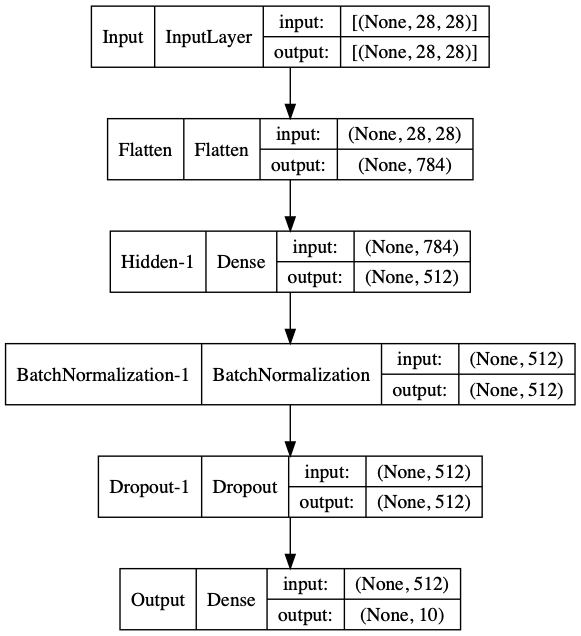

In [12]:
plot_model(mlp_model,
           to_file='./images/mlp_model_architecture.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB',
           dpi=100,
          )

### *Model Evaluation* <a class='anchor' id='mlp_evaluation'></a>

- *In this step, we will evaluate the performance of our model*
- *In particular, we will evaluate its performance both during the training phase and making predictions*
- *For this reason, we will create a function which will help us to plot the learning curves*

##### *Define a function to plot learning curves*

In [13]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.savefig(f'./images/mlp_learning_curves_{metric}.svg')
    plt.show()

##### *Evaluation on training and validation data*

Train Loss     : 0.16064
Validation Loss: 0.28798
---
Train Accuracy     : 0.94117
Validation Accuracy: 0.90050



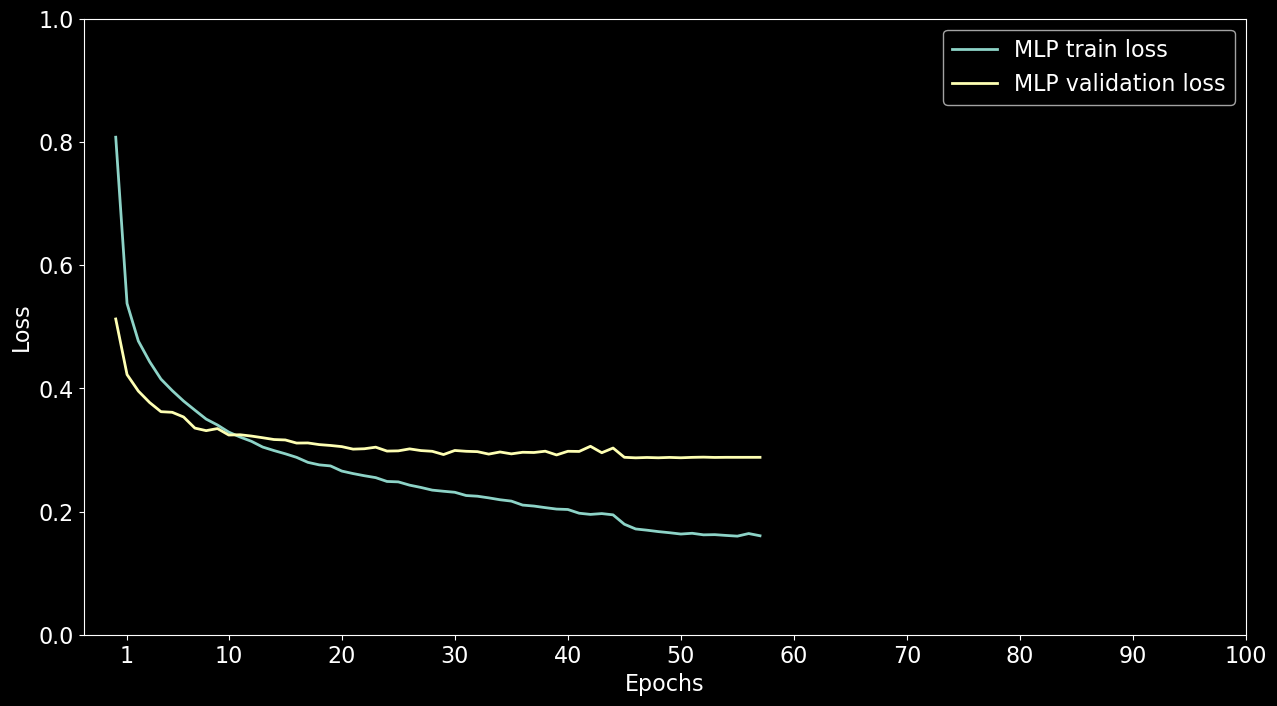

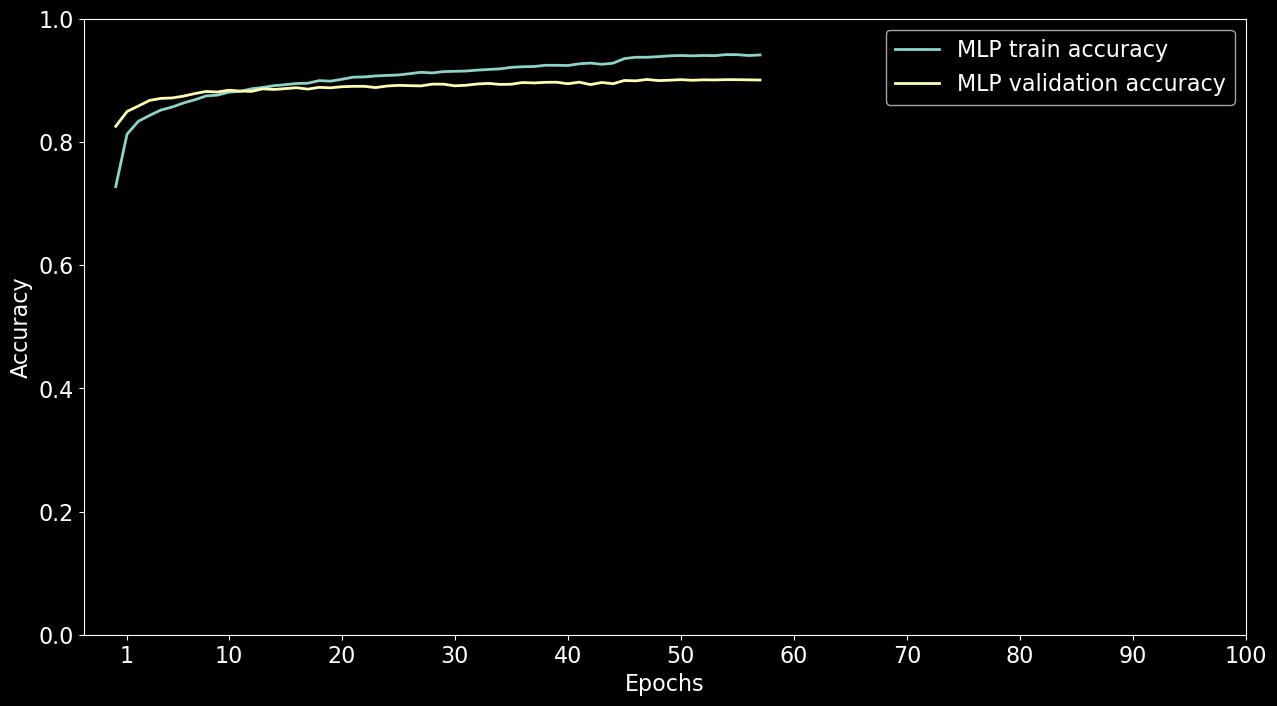

In [14]:
print('Train Loss     : {0:.5f}'.format(mlp_hs.history['loss'][-1]))
print('Validation Loss: {0:.5f}'.format(mlp_hs.history['val_loss'][-1]))
print('---')
print('Train Accuracy     : {0:.5f}'.format(mlp_hs.history['accuracy'][-1]))
print('Validation Accuracy: {0:.5f}'.format(mlp_hs.history['val_accuracy'][-1]))

# plot train and validation error per epoch
plot_history(hs={'MLP': mlp_hs}, epochs=100, metric='loss')
plot_history(hs={'MLP': mlp_hs}, epochs=100, metric='accuracy')

##### *Evaluation on test data*

In [15]:
# evaluate on test data
mlp_eval = mlp_model.evaluate(x_test, y_test_cat, verbose=2)

# print results
print()
print('Test Loss    : {0:.5f}'.format(mlp_eval[0]))
print('Test Accuracy: {0:.5f}'.format(mlp_eval[1]))

313/313 - 3s - loss: 0.3088 - accuracy: 0.8950 - 3s/epoch - 9ms/step

Test Loss    : 0.30879
Test Accuracy: 0.89500


In [16]:
# make predictions
predictions = mlp_model.predict(x_test)
predictions = np.argmax(predictions, axis=1)

##### *Display the classification report*

In [17]:
# define class names
class_names = [
    'T-Shirt/Top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle Boot'
]

# print the classification report
print(classification_report(y_test, predictions, target_names=class_names))

              precision    recall  f1-score   support

 T-Shirt/Top       0.85      0.84      0.84      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.81      0.82      0.82      1000
       Dress       0.89      0.91      0.90      1000
        Coat       0.81      0.83      0.82      1000
      Sandal       0.98      0.97      0.97      1000
       Shirt       0.73      0.70      0.72      1000
     Sneaker       0.94      0.97      0.95      1000
         Bag       0.97      0.97      0.97      1000
  Ankle Boot       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.90      0.89     10000



##### *Display the confusion matrix*

In [18]:
# create the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# pass the confusion matrix into a dataframe
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

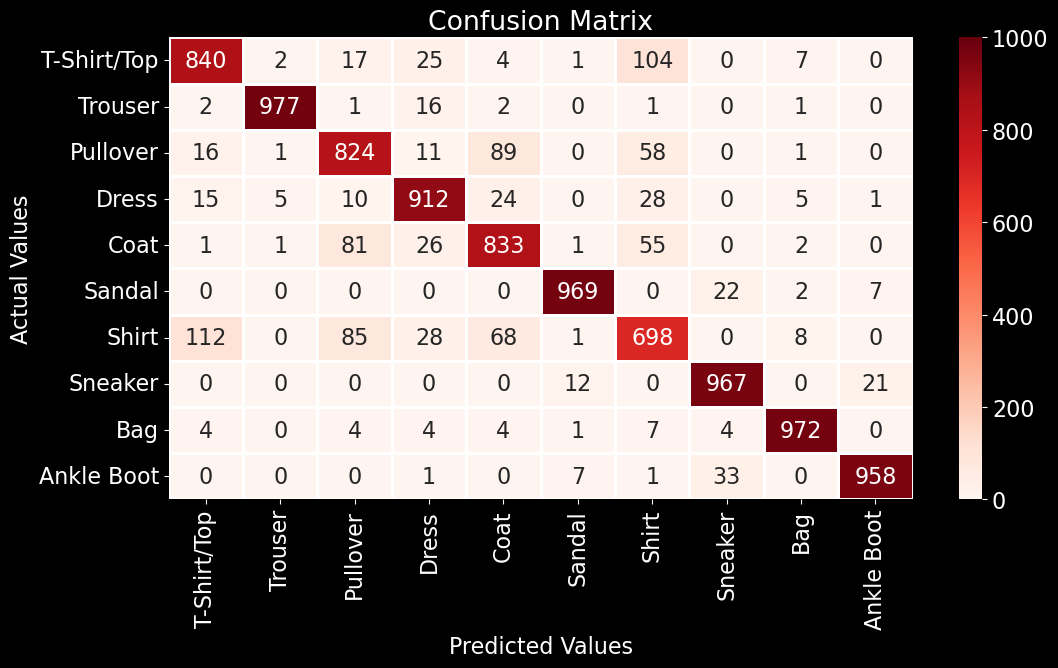

In [19]:
# initialize plot settings
cmap = sns.color_palette('Reds', as_cmap=True)

# plot the confusion matrix
plt.figure(figsize=(12,6),dpi=100)
sns.heatmap(df_conf_matrix, annot=True, fmt='g', vmax=1000, cmap=cmap, linewidths=1.0)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.title('Confusion Matrix')
plt.show()

##### *Clean up the `mlp_model` variable (not necessary)*

In [20]:
# clean the model
clean_up(mlp_model)

---

*Thank you!*

---